In [2]:
import pandas as pd
import numpy as np

# graphics packages
import seaborn as sns
sns.set(color_codes=True)
import matplotlib.pyplot as plt

%matplotlib inline

## Problem 1

### Question 1: You should download and combine data from the open data portal for 2017 about the following 311 requests: Graffiti Removal, Vacant and Abandoned Buildings Reported, Alley Lights Out

**Step 1: understanding the data schema** The first thing that I wanted to do was read in the data and identify what fields I was working with. I also knew that I would have to fill nulls in. 

In [3]:
# import csv files
graffiti = pd.read_csv('./311_Service_Requests_-_Graffiti_Removal.csv').fillna('unknown')
vacant = pd.read_csv('./311_Service_Requests_-_Vacant_and_Abandoned_Buildings_Reported.csv').fillna('unknown')
alleys = pd.read_csv('./311_Service_Requests_-_Alley_Lights_Out.csv').fillna('unknown')

In [4]:
print(graffiti.columns)
print(vacant.columns)
print(alleys.columns)

Index(['Creation Date', 'Status', 'Completion Date', 'Service Request Number',
       'Type of Service Request', 'What Type of Surface is the Graffiti on?',
       'Where is the Graffiti located?', 'Street Address', 'ZIP Code',
       'X Coordinate', 'Y Coordinate', 'Ward', 'Police District',
       'Community Area', 'SSA', 'Latitude', 'Longitude', 'Location'],
      dtype='object')
Index(['SERVICE REQUEST TYPE', 'SERVICE REQUEST NUMBER',
       'DATE SERVICE REQUEST WAS RECEIVED',
       'LOCATION OF BUILDING ON THE LOT (IF GARAGE, CHANGE TYPE CODE TO BGD).',
       'IS THE BUILDING DANGEROUS OR HAZARDOUS?',
       'IS BUILDING OPEN OR BOARDED?',
       'IF THE BUILDING IS OPEN, WHERE IS THE ENTRY POINT?',
       'IS THE BUILDING CURRENTLY VACANT OR OCCUPIED?',
       'IS THE BUILDING VACANT DUE TO FIRE?',
       'ANY PEOPLE USING PROPERTY? (HOMELESS, CHILDEN, GANGS)',
       'ADDRESS STREET NUMBER', 'ADDRESS STREET DIRECTION',
       'ADDRESS STREET NAME', 'ADDRESS STREET SUFFIX', 'Z

In [5]:
# this is a sample exploratory analysis line -- it was to show me how to collapse values
vacant['IS BUILDING OPEN OR BOARDED?'].unique()

array(['unknown', 'Building is Open / Unsecure', 'Building is Boarded Up',
       'Open', 'Boarded'], dtype=object)

**Step 2: Preliminary data cleaning** I then wanted to clean the data up a little and standardize it so that all of the frames could be easily concatenated into one large dataframe. I did this per dataframe so that I could reduce errors. 

In [6]:
# create type and subtype columns for each dataframe
vacant['reqtype'] = vacant['SERVICE REQUEST TYPE']

# we care more that it is definitely boarded than if it is not
vacant['boarded'] = np.where(vacant['IS BUILDING OPEN OR BOARDED?'].str.match('Boarded'), 'boarded', 'not_boarded')

# fire, in use vacancy (dangerous and hazardous always na)
vacant['fire'] = np.where(vacant['IS THE BUILDING VACANT DUE TO FIRE?'], 'fire_vacancy', 'not_fire')
vacant['in_use'] = np.where(vacant['ANY PEOPLE USING PROPERTY? (HOMELESS, CHILDEN, GANGS)'], 'in_use', 'not_in_use')

# vacancy subtype
vacant['subtype'] = vacant[['boarded', 'fire', 'in_use']].apply(lambda x: "_".join(x), axis=1)

# create a status indicator
vacant['Status'] = np.where(vacant['DATE SERVICE REQUEST WAS RECEIVED'].isnull(), 'Open', 'Completed')
vacant['completed date'] =  ['Not_applicable'] * vacant['SERVICE REQUEST TYPE'].count()

# now we do the same thing for the other two dfs
graffiti['reqtype'] = graffiti['Type of Service Request']
graffiti['subtype'] = graffiti[['What Type of Surface is the Graffiti on?',
                                'Where is the Graffiti located?']].apply(lambda x: "_".join(x), axis=1)
alleys['reqtype'] = alleys['Type of Service Request']
alleys['subtype'] = alleys['Type of Service Request']

**Step 3: Data merging** The final step in ensuring that the dataframes are ready for the merge is selecting the columns to retain and setting new indices. Then, we merge the frames. 

In [7]:
perm_cols = ['Status', 'Service Request Number', 'Creation Date', 
             'Completion Date', 'Police District', 'Community Area', 'Latitude',
             'Longitude','reqtype', 'subtype']

vacant_merge = vacant[[ 'Status', 'SERVICE REQUEST NUMBER', 'DATE SERVICE REQUEST WAS RECEIVED', 'completed date',
                       'Police District',
                       'Community Area', 'LATITUDE', 'LONGITUDE', 'reqtype','subtype']]
vacant_merge.columns = perm_cols
vacant_merge.set_index('Service Request Number')

alleys_merge = alleys[perm_cols]
alleys_merge.set_index('Service Request Number')

graffiti_merge = graffiti[perm_cols]
graffiti_merge.set_index('Service Request Number')

all_311 = pd.concat([vacant_merge, alleys_merge, graffiti_merge]).set_index('Service Request Number')

At this point, all of the data is combined into one dataframe, named **all_311**

### Question 2: Generate summary statistics for these requests including but not limited to number of requests of each type (and subtype within each of the types above) over time, by neighborhood, response time by the city. Please use a combination of tables and graphs to present these summary stats.

In [8]:
# police districts crosswalk -- for labelling 
districts = {
    1: "ctr",
    2: 'wworth',
    3: 'gr cross', 
    4: 's chi', 
    5: 'cal', 
    6: 'gresham', 
    7: 'englwd', 
    8: 'chi lawn', 
    9: 'drng', 
    10: 'ogdn', 
    11: 'hrrsn', 
    12: 'nr w', 
    14: 'shkspr', 
    15: 'austin', 
    16: 'jeff prk', 
    17: 'alb prk', 
    18: 'n nrth', 
    19: 'twn hll', 
    20: 'lncln',
    22: 'mgn prk',
    24: 'rgrs prk',
    25: 'grnd ctrl'
}

all_311['neighborhood'] = \
    all_311.apply(lambda x: districts.get(x['Police District'], 'Unknown'), axis=1)

In [9]:
# first, I just want to get a sense of how many of these complaints are open / completed
all_311.groupby(['reqtype', 'Status']).size()

reqtype                    Status         
Alley Light Out            Completed          107346
                           Completed - Dup     83715
                           Open                 4260
                           Open - Dup           4269
Graffiti Removal           Completed          887889
                           Completed - Dup     85923
                           Open                  128
                           Open - Dup             15
Vacant/Abandoned Building  Completed           62125
dtype: int64

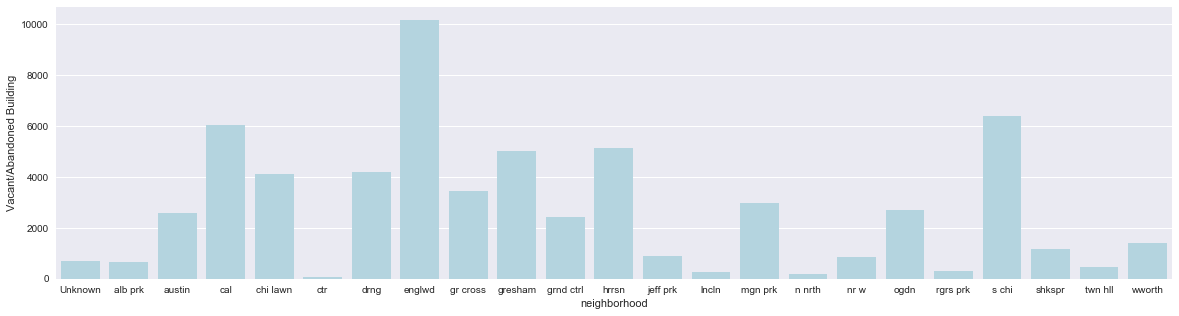

In [10]:
# make a bar chart by neighborhood for the number of complaints
grouped = all_311.groupby(['neighborhood', 'reqtype']).size().unstack().reset_index()

plt.subplots(figsize=(20,5))
sns.barplot(x="neighborhood", y="Vacant/Abandoned Building", data=grouped, color='lightblue')

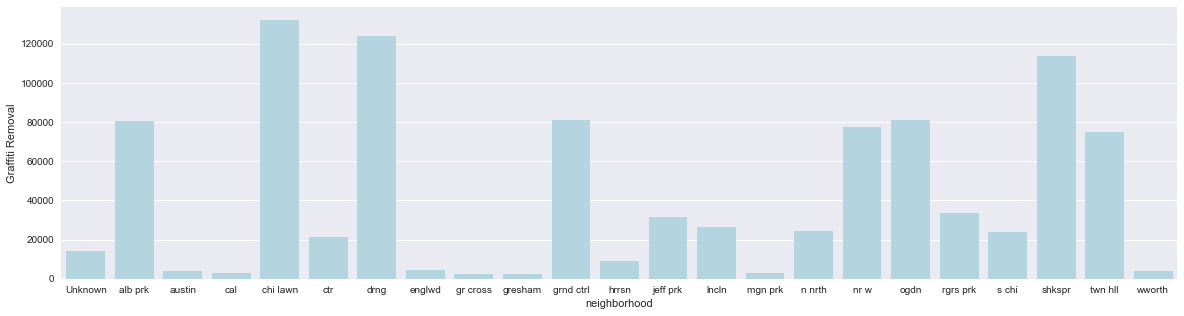

In [11]:
plt.subplots(figsize=(20,5))
sns.barplot(x="neighborhood", y="Graffiti Removal", data=grouped, color='lightblue')

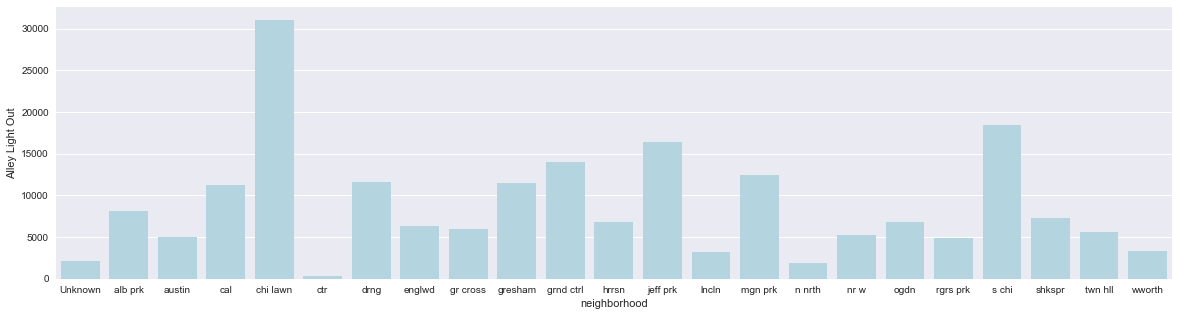

In [12]:
plt.subplots(figsize=(20,5))
sns.barplot(x="neighborhood", y="Alley Light Out", data=grouped, color='lightblue')

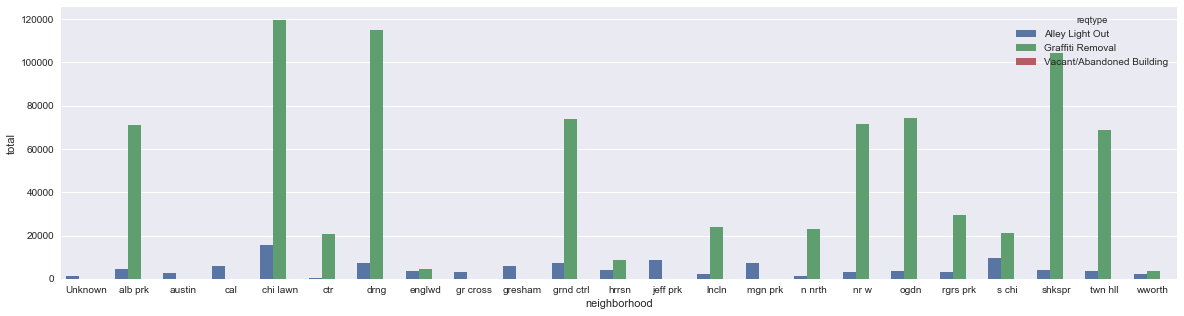

In [13]:
plt.subplots(figsize=(20,5))
grouped = all_311.groupby(['neighborhood', 'reqtype', 'Status']).size().unstack().reset_index()
grouped['total'] = grouped['Open'] + grouped['Completed']
sns.barplot(x='neighborhood', y='total', hue='reqtype', data=grouped)

In [14]:
grouped = all_311.groupby(['Creation Date', 'reqtype']).size().unstack().reset_index().fillna(0).set_index('Creation Date')
grouped.index = grouped.index.to_datetime()
grouped['date'] = grouped.index

/Users/emmanechamkin/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: to_datetime is deprecated. Use pd.to_datetime(...)
  


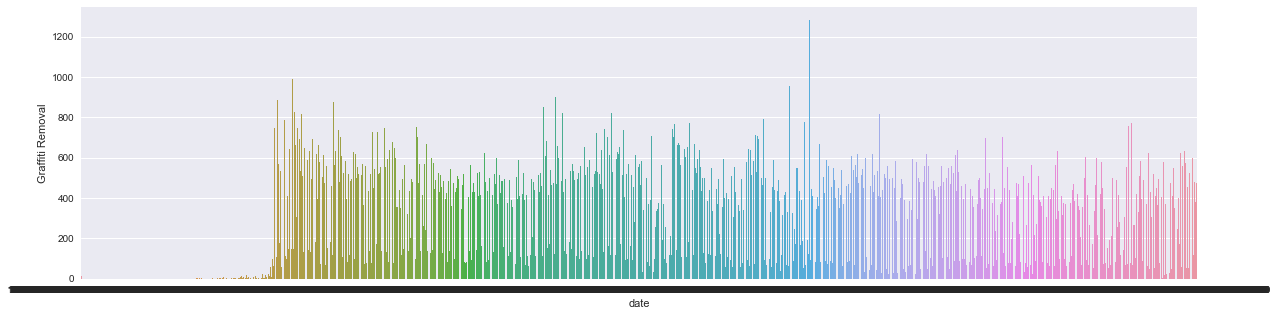

In [15]:
plt.subplots(figsize=(20,5))
sns.barplot(x='date', y='Graffiti Removal', data=grouped)

In [16]:
all_311.groupby(['reqtype', 'subtype','Status']).size()

reqtype                    subtype                              Status         
Alley Light Out            Alley Light Out                      Completed          107346
                                                                Completed - Dup     83715
                                                                Open                 4260
                                                                Open - Dup           4269
Graffiti Removal           Aluminum Siding_Alley                Completed            1992
                                                                Completed - Dup       463
                                                                Open                    1
                           Aluminum Siding_Bench                Completed               5
                           Aluminum Siding_Door                 Completed             392
                                                                Completed - Dup        47
                    

Based on these summary statistics, tell me 5 interesting things you learned
(about Chicago and the different neighborhoods) using the 311 data

1. Graffiti is -- by a wide margin, the most common 311 call of the three noted. 
2. There is significant variance among neighborhoods in 311 calls. 
3. Vacancy is the least common reported crime, and almost half of vacant homes are in use. 
4. 311 calls are decreasing on average, over time (but not super significantly). 
5. [Add a response time thing here]

## Problem 2

### All of the service requests you just analyzed have address and lat/long fields. The task is to augment that data with American Community Survey data. For each address, use one of the census APIs to get some additional data (at least 3-4 useful variables) about the block where the 311 request came from

In [203]:
acs_tracts = pd.read_csv()

Index(['Status', 'Creation Date', 'Completion Date', 'Police District',
       'Community Area', 'Latitude', 'Longitude', 'reqtype', 'subtype',
       'neighborhood'],
      dtype='object')